In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from matplotlib import gridspec, patches
from tqdm import tqdm, trange
from sklearn.metrics import confusion_matrix
from scipy.stats import poisson, norm
from sklearn.decomposition import PCA
import sys
sys.path.append("/home/camp/warnert")
sys.path.append("/home/camp/warnert/working/Recordings/binary_pulses/blip_manuscript")
import blip_analysis_manu as ba
import exp_blip_models_manu as em
import daskify
import dask
from scipy.stats import skewnorm, mannwhitneyu
import scipy
import matplotlib
from sklearn.manifold import LocallyLinearEmbedding, MDS
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from scipy.spatial import distance_matrix
import openephys as oe

Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 1408 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 4608 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 4288 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 1440 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 5328 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 5328 trials in trial name file
Respiration peaks found
Found file

In [2]:
glyphs = []
for i in ba.get_trial_array():
    glyph_str = ''
    for j in i:
        if j == 1:
            glyph_str+='\u25AE'
        else:
            glyph_str += '\u25AF'



    glyphs.append(glyph_str)
    print(glyph_str)

▯▯▯▯▯
▯▯▯▯▮
▯▯▯▮▯
▯▯▯▮▮
▯▯▮▯▯
▯▯▮▯▮
▯▯▮▮▯
▯▯▮▮▮
▯▮▯▯▯
▯▮▯▯▮
▯▮▯▮▯
▯▮▯▮▮
▯▮▮▯▯
▯▮▮▯▮
▯▮▮▮▯
▯▮▮▮▮
▮▯▯▯▯
▮▯▯▯▮
▮▯▯▮▯
▮▯▯▮▮
▮▯▮▯▯
▮▯▮▯▮
▮▯▮▮▯
▮▯▮▮▮
▮▮▯▯▯
▮▮▯▯▮
▮▮▯▮▯
▮▮▯▮▮
▮▮▮▯▯
▮▮▮▯▮
▮▮▮▮▯
▮▮▮▮▮


In [3]:
ba.units_usrts[1] = None
units_usrt1 = ba.get_usrts(1, pre_trial_window=1, post_trial_window=1)
# units_usrt2 = ba.get_usrts(3)
# units_usrt3 = ba.get_usrts(5)

/home/camp/warnert/neurolytics/joined_recording.py:79: UserWarning: Mismatch in repeat lengths, cannot make full numpy array
  warnings.warn('Mismatch in repeat lengths, cannot make full numpy array')


In [4]:
print(units_usrt1[0][0].shape)

(11, 212)


In [5]:
def split_bs_data(usrt, test_size=1, bs_size=60):
    train = []
    test = []
    for unit in usrt:
        unit_train = []
        unit_test = []
        for stimuli in unit:
            test_repeat_index = np.random.choice(np.arange(len(stimuli)), size=1)
            rest_index = np.arange(len(stimuli))
            rest_index = np.delete(rest_index, test_repeat_index)
            bs_indexes = np.random.choice(rest_index, size=bs_size, replace=True)
            bs_data = stimuli[bs_indexes]
            unit_train.append(bs_data)
            unit_test.append(stimuli[test_repeat_index])
        train.append(unit_train)
        test.append(unit_test)
    train = np.array(train)
    test = np.array(test)
    return train, test

In [242]:
train, test = split_bs_data(units_usrt1)

In [21]:
print(train.sum(axis=-1).shape)
print(test.sum(axis=-1)[:, :, 0].shape)
y_train = [i for i in range(32) for j in range(60)]


(145, 32, 60)
(145, 32)


In [24]:
train, test = split_bs_data(units_usrt1)
train = train.sum(axis=-1).reshape(145, -1)
test = test.sum(axis=-1).reshape(145, -1)
y_train = [i for i in range(32) for j in range(60)]
y_test = list(range(32))
svm = LinearSVC(C=1000, max_iter=100000)
svm.fit(train.T, y_train)
svm.predict(test.T)

array([ 1,  3,  3,  3,  7,  5,  5, 10, 18, 10, 11, 21, 13, 17, 11, 15, 24,
       17, 20, 20, 16, 14, 20, 13, 26, 12, 25, 23, 27, 28, 27, 29])

In [6]:
def svm_fit(usrt, bs_size=60):
    train, test= split_bs_data(usrt)
    train = train.sum(axis=-1).reshape(145, -1)
    test = test.sum(axis=-1).reshape(145, -1)
    y_train = [i for i in range(32) for j in range(bs_size)]
    y_test = list(range(32))
    svm = LinearSVC(C=1000, max_iter=100000)
    svm.fit(train.T, y_train)
    pred = svm.predict(test.T)
    return pred, y_test

In [320]:
joined_usrt = np.concatenate([units_usrt1, units_usrt2, units_usrt3], axis=1)
print(joined_usrt.shape)

(145, 96)


In [365]:
train, test = split_bs_data(units_usrt1)
onset = 10
window_size = 50
train[:, :, :, onset:onset+window_size]
test.shape

(145, 32, 1, 212)

In [7]:
def svm_fit_all(usrts, bs_size=60):
    train, test= split_bs_data(usrts)
    train = train.sum(axis=-1).reshape(145, -1)
    test = test.sum(axis=-1).reshape(145, -1)
    y_train = [i for i in range(96) for j in range(bs_size)]
    y_test = list(range(96))
    svm = LinearSVC(C=1000, max_iter=100000)
    svm.fit(train.T, y_train)
    pred = svm.predict(test.T)
    return pred, y_test

In [8]:
def svm_fit_window(usrt, onset, window_size, bs_size=60):
    train, test= split_bs_data(usrt)
    train =train[:, :, :, onset:onset+window_size].sum(axis=-1).reshape(145, -1)
    test =test[:, :, :, onset:onset+window_size].sum(axis=-1).reshape(145, -1)
    y_train = [i for i in range(32) for j in range(bs_size)]
    y_test = list(range(32))
    svm = LinearSVC(C=1000, max_iter=100000)
    svm.fit(train.T, y_train)
    pred = svm.predict(test.T)
    return pred, y_test, onset

In [370]:
pred, y_test, onset = svm_fit_window(units_usrt1, 10, 50)

/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [373]:
print(onset)

10


In [26]:
pred, y_test = svm_fit(units_usrt1)

In [416]:
dasked = daskify.Daskified()

In [417]:
dasked.start_cluster()

/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35743 instead
  http_address["port"], self.http_server.port


In [418]:
client = dasked.client

In [419]:
scatterd_usrt1 = client.scatter(units_usrt1)
# scatterd_usrt2 = client.scatter(units_usrt2)
# scatterd_usrt3 = client.scatter(units_usrt3)

In [322]:
scattered_joined = client.scatter(joined_usrt)

In [244]:
futures = [dask.delayed(svm_fit)(scatterd_usrt1) for i in range(500)]

In [323]:
futures = [dask.delayed(svm_fit_all)(scattered_joined) for i in range(500)]

In [425]:
futures = [[dask.delayed(svm_fit_window)(scatterd_usrt1, j, 50) for i in range(100)] for j in range(212-50)]
futures = list(np.concatenate(futures))

In [410]:
print(futures[0])

Delayed('svm_fit_window-04192990-9ba1-428b-9ee5-d852642575aa')


In [415]:
client.close()

In [428]:
dask_outs = client.compute(futures)

In [407]:
print(len(dask_outs))

81000


In [412]:
print(dask_outs[0][0][0].status)

Delayed('getattr-e36c12da7d6a5f8f56d1d0e49b39ac97')


In [422]:
print(dask_outs[0].status)

Delayed('getattr-668ee730701f863bef8cebec7c52cdad')


In [561]:
status = np.array([i.status for i in dask_outs])
print(list(set(status)))
for i in list(set(status)):
    print(i, len(status[status == i]))

['finished']
finished 16200


In [562]:
reses_window = [i.result() for i in tqdm(dask_outs, position=0, leave=False)]

100%|█████████▉| 16145/16200 [00:28<00:00, 588.26it/s]


In [563]:
onsets = [i[-1] for i in reses_window]
reses_window = [[i[0], i[1]] for i in reses_window]

In [574]:
reses_window = np.array(reses_window)
onsets = np.array(onsets)
preds_window = reses_window[:, 0].reshape(162, 100, 32)
trues_window = reses_window[:, 1].reshape(162, 100, 32)
print(preds_window.shape)
print(preds_window.reshape(162, 100, 32).shape)
onsets_reshape = onsets.reshape(162, 100)


(162, 100, 32)
(162, 100, 32)


In [577]:
print(trues_window[0].shape)

(100, 32)


In [5]:
cms_window = np.array([confusion_matrix(np.concatenate(trues_window[i]), np.concatenate(preds_window[i]), labels=list(range(32)), normalize='true') for i in range(162)])

In [590]:
print(np.max(cms_window))

0.74


In [7]:
avg_accs = [np.mean([i[j, j] for j in range(32)]) for i in cms_window]

In [620]:
np.save('221017_preds_window.npy', preds_window)
np.save('221017_trues_window.npy', trues_window)

In [3]:
preds_window = np.load('221017_preds_window.npy')
trues_window = np.load('221017_trues_window.npy')

In [20]:
mean_usrt = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt1])
print(mean_usrt.shape)

(145, 32, 212)


In [62]:


times = np.arange(-1, 0.62, 1/100)
for index, i in enumerate(times):
    fig = plt.figure(figsize=(8, 5), dpi=150)
    gs = gridspec.GridSpec(2, 4, hspace=.4)
    
    resp_ax = fig.add_subplot(gs[0, 1:3])
    
    avg_ax = fig.add_subplot(gs[1, :2])
    cm_ax = fig.add_subplot(gs[1, 2:])
    im = cm_ax.imshow(cms_window[index], cmap='pink', vmax=0.74)
    fig.suptitle(f'Onset: {i:0.2}s')
    cm_ax.set_xticks(range(32))
    cm_ax.set_xticklabels(glyphs, rotation=90, fontsize=4)
    cm_ax.set_yticks(range(32))
    cm_ax.set_yticklabels(glyphs, fontsize=4)
    plt.colorbar(ax = cm_ax, mappable=im)
    cm_ax.set_ylim(31.5, -.5)
    
    avg_ax.plot(times, avg_accs, color='k')
    avg_ax.scatter(i, avg_accs[index], color='r', zorder=10)
    #avg_ax.axvspan(-.5, 0, color='lightgray')
    avg_ax.set_xlabel('Onset (s)')
    avg_ax.set_ylabel('Average accuracy')
    cm_ax.set_ylabel('True label')
    cm_ax.set_xlabel('Predicted label')
    
    xs = np.arange(-1, 1.12, 1/100)
    resp_ax.plot(xs, mean_usrt[40, -1])
    resp_ax.axvspan(0, 0.1, color='lightgray')
    resp_ax.set_xlabel('Time (s)')
    resp_ax.set_ylabel('Firing rate (Hz)')
    ylims = resp_ax.get_ylim()
    rect = patches.Rectangle((i, ylims[0]+1), 0.5, ylims[1]+2, linewidth=1, edgecolor='r', facecolor='none', linestyle='--')
    resp_ax.add_patch(rect)

    plt.savefig(f'Avg_accuracy_cms/{index}.png')
    plt.close()

In [ ]:
reses = [i.result() for i in tqdm(dask_outs)]

In [345]:
reses = np.array(reses)
print(reses.shape)

(500, 2, 96)


In [346]:
preds = reses[:, 0]
trues = reses[:, 1]

In [347]:
cm = confusion_matrix(np.concatenate(trues), np.concatenate(preds), labels=list(range(96)), normalize='true')

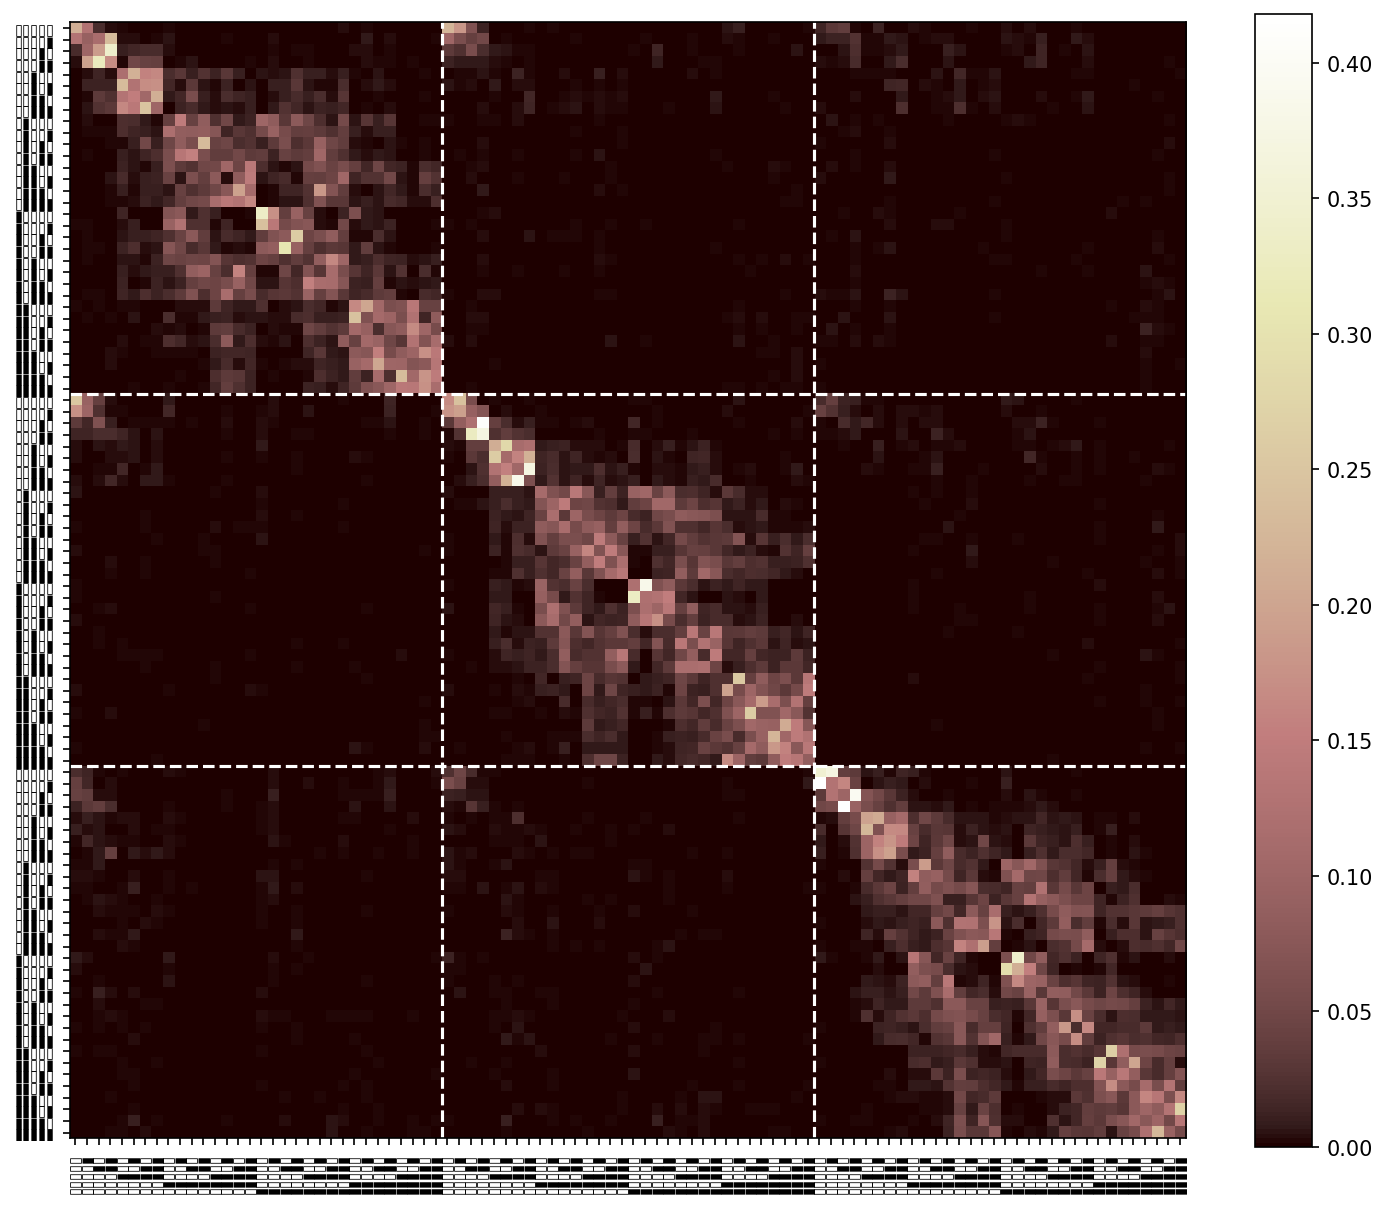

In [358]:
plt.figure(figsize=(12, 10), dpi=150)
plt.imshow(cm, cmap='pink')
plt.xticks(range(96), labels=glyphs*3, rotation=90, fontsize=7);
plt.yticks(range(96), labels=glyphs*3, fontsize=7);
plt.ylim(95.5, -.5)
plt.colorbar()
plt.axhline(31.5, linestyle='--', color='white')
plt.axhline(63.5, linestyle='--', color='white')

plt.axvline(31.5, linestyle='--', color='white')
plt.axvline(63.5, linestyle='--', color='white')

(1.5, -0.5)

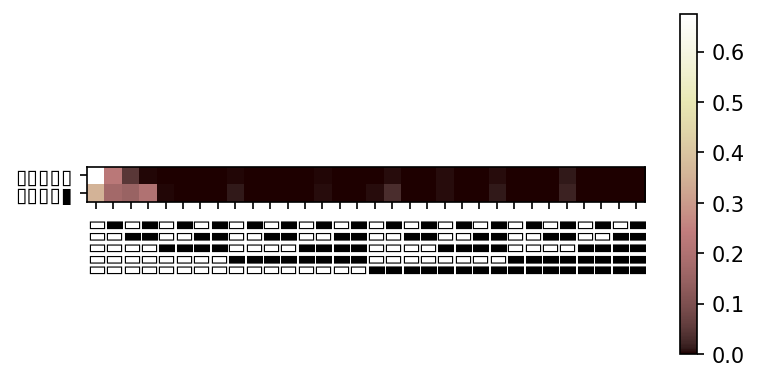

In [315]:
plt.figure(figsize=(6, 3), dpi=150)
plt.imshow(cm[:2], cmap='pink')
plt.xticks(range(32), labels=glyphs, rotation=90, fontsize=10);
plt.yticks(range(2), labels=glyphs[:2], fontsize=10);
plt.colorbar()
plt.ylim(1.5, -.5)


/camp/home/warnert/.conda/envs/intan/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


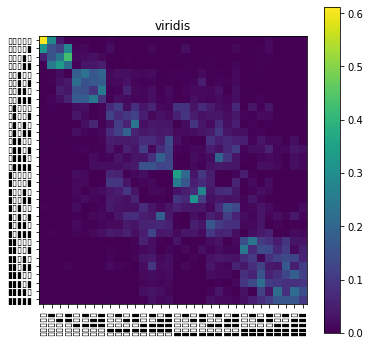

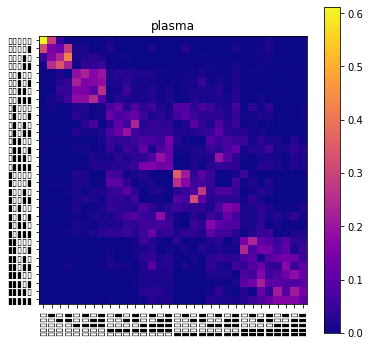

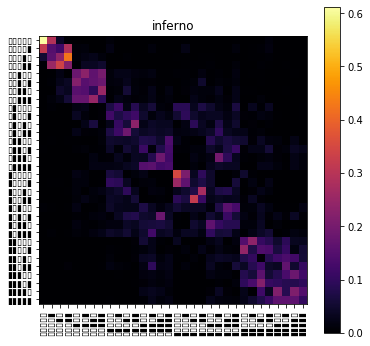

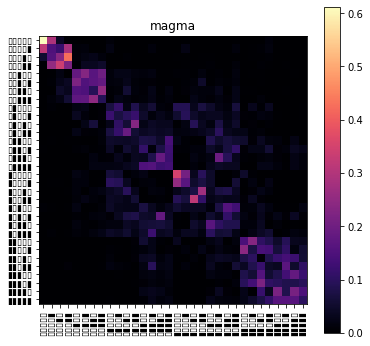

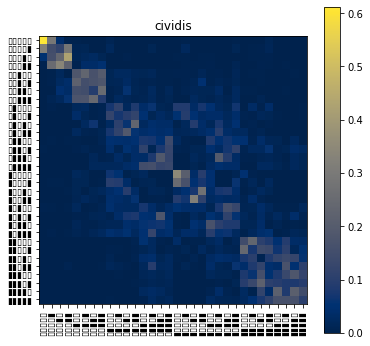

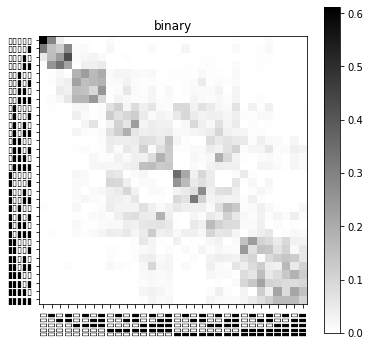

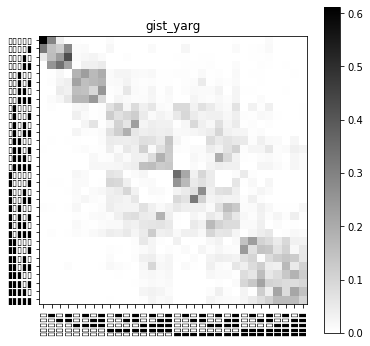

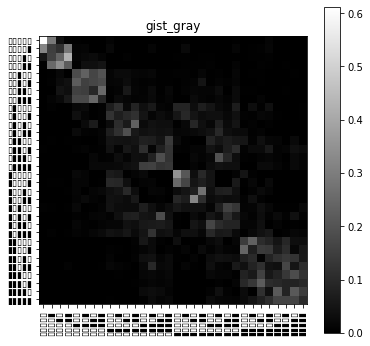

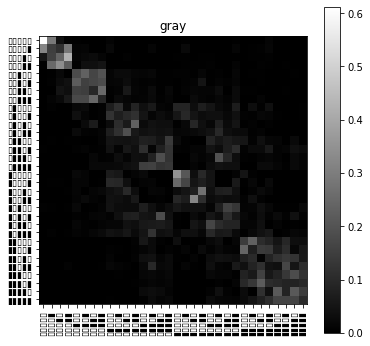

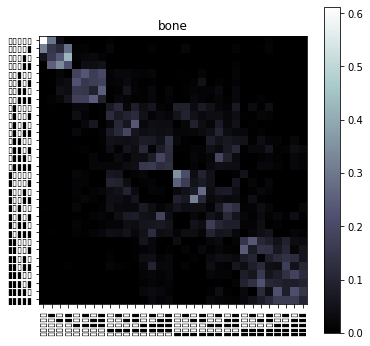

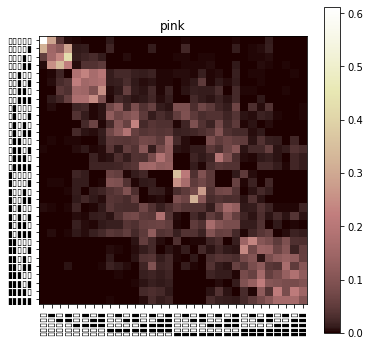

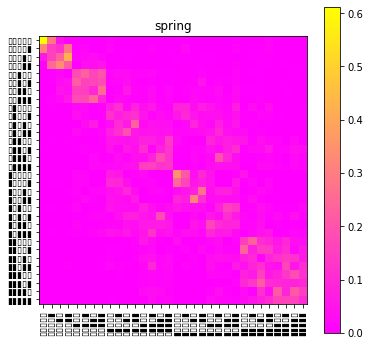

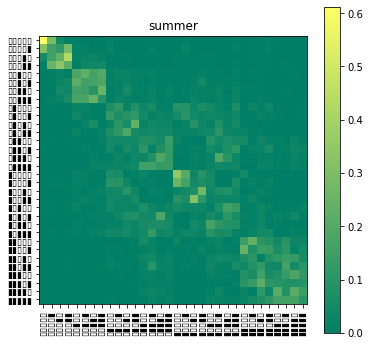

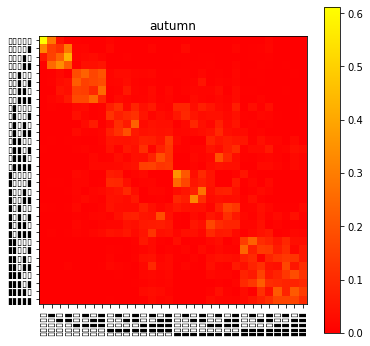

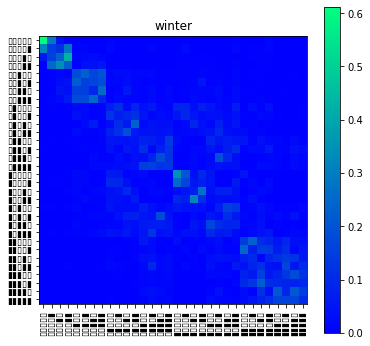

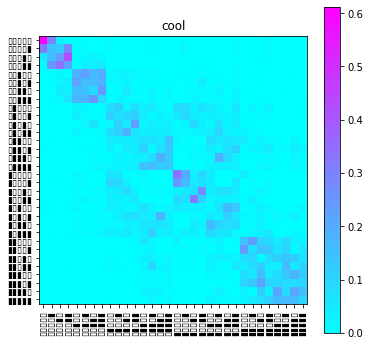

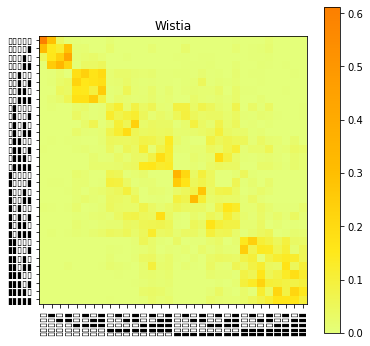

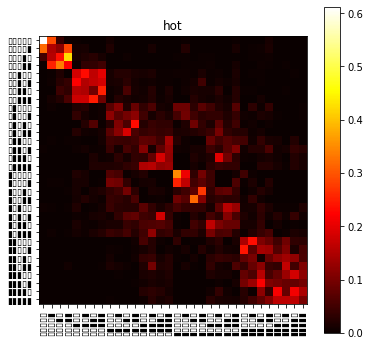

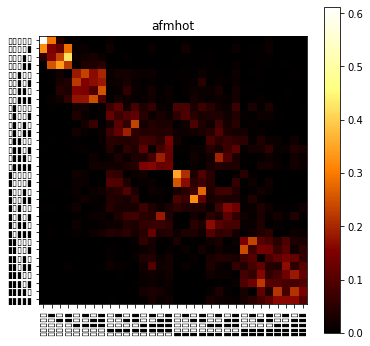

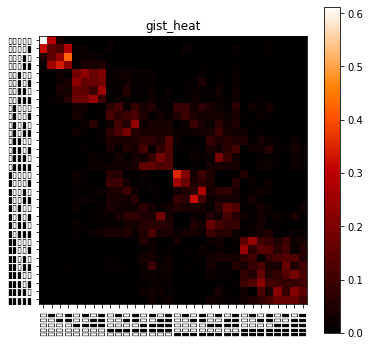

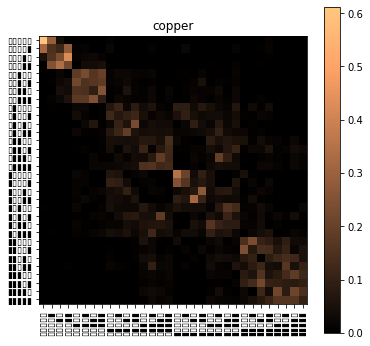

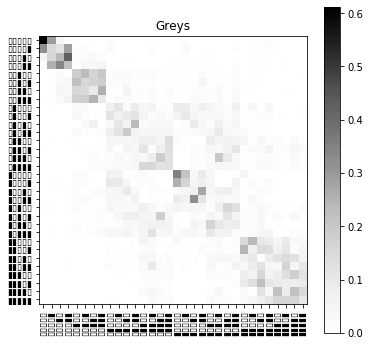

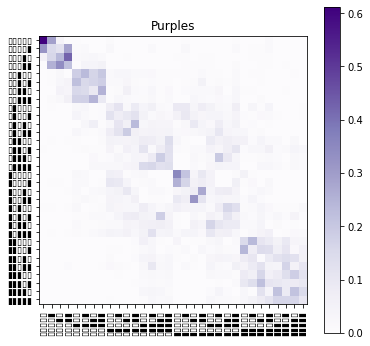

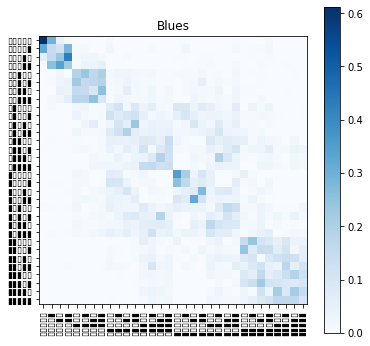

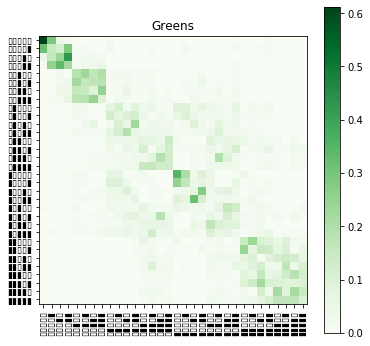

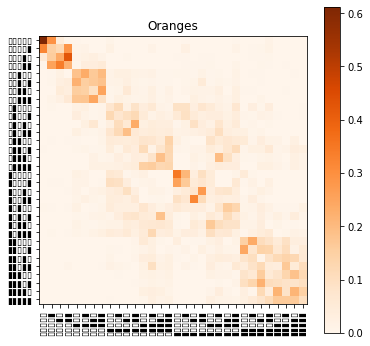

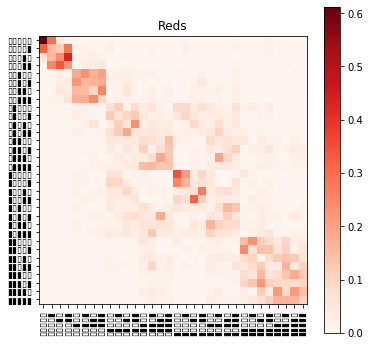

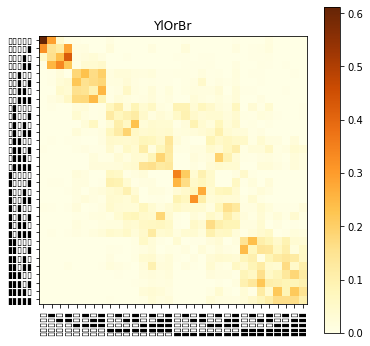

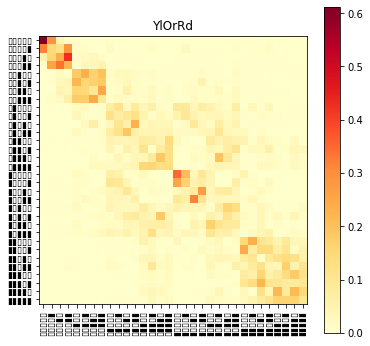

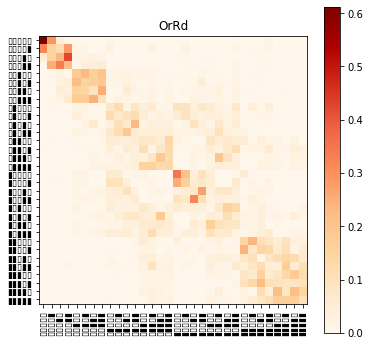

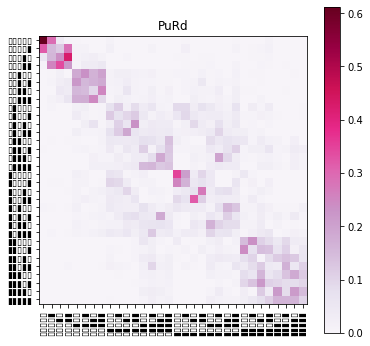

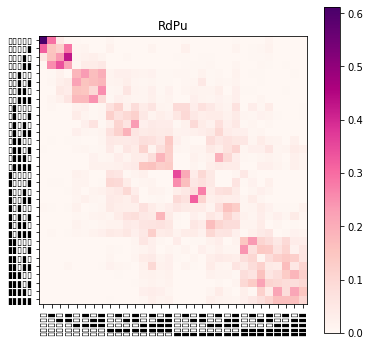

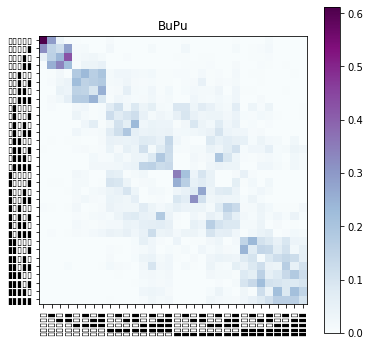

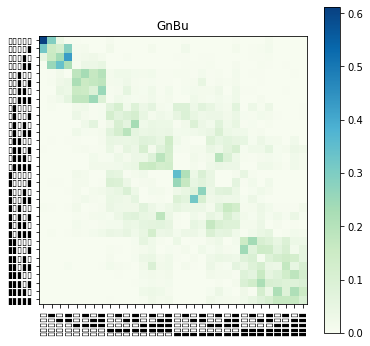

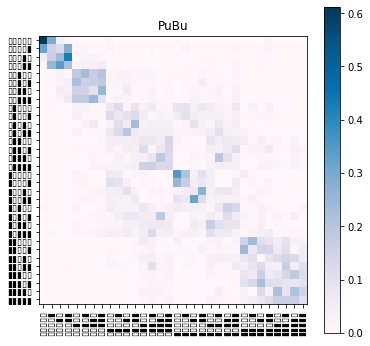

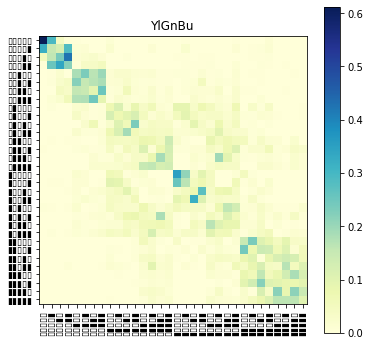

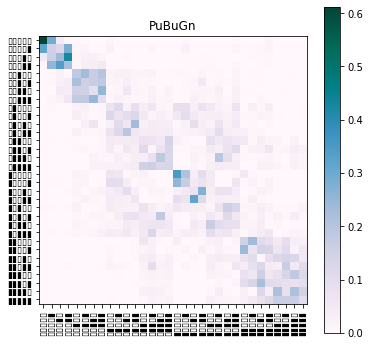

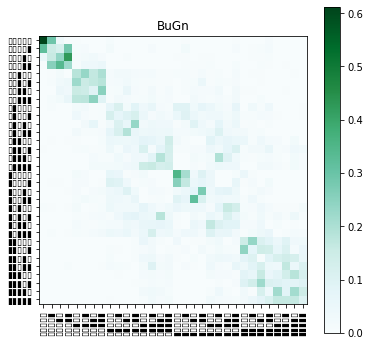

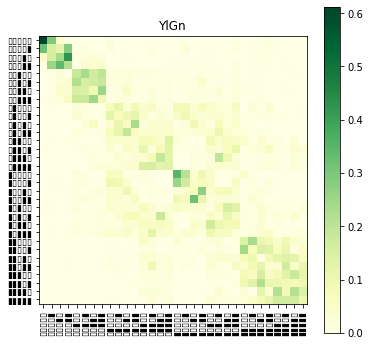

In [22]:
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper','Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
for i in range(len(cmaps)):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, cmap=cmaps[i], vmin=0)
    plt.title(cmaps[i])
    plt.xticks(range(32), labels=glyphs, rotation=90, fontsize=9)
    plt.yticks(range(32), labels=glyphs, fontsize=9)
    plt.ylim(31.5, -.5)
    plt.colorbar()

In [78]:
mean_usrt = np.array([[np.mean(i, axis=0) for i in j] for j in units_usrt1])

print(mean_usrt.shape)

(145, 32, 212)


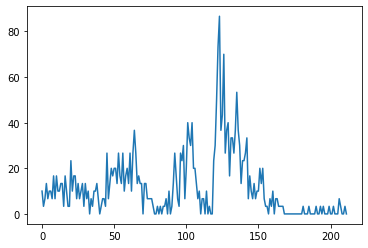

In [79]:
plt.plot(mean_usrt[40, -1])

In [25]:
mean_usrt1_scattered = client.scatter(mean_usrt)

In [96]:
dms = [distance_matrix(mean_usrt[:, :, i:i+50].mean(axis=-1).T, mean_usrt[:, :, i:i+50].mean(axis=-1).T) for i in range(212-50)]


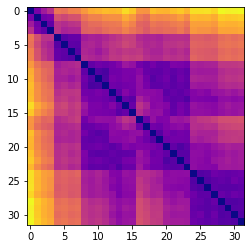

In [84]:
plt.imshow(dms[100], cmap='plasma')

In [26]:
dms1_scattered = client.scatter(dms)

In [7]:
print(dms[0].shape)

(32, 32)


In [29]:
def de_minimisation(coords, true_distances):
    coords = coords[:, np.newaxis]
    #print(coords)

    dm = distance_matrix(coords, coords)
    dm_off = np.triu(dm, 1)
    
#     loss = np.sum(np.abs(true_distances.ravel() - dm.ravel()))
#     return loss

15.5


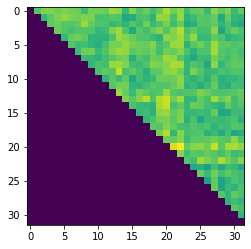

In [212]:
plt.imshow(np.triu(dms[0], k=0))
dm_ravel = np.triu(dms[0], k=0).ravel()
dm_ravel = dm_ravel[dm_ravel > 0]

print(dm_ravel.shape[0]/32)

In [505]:
rec = ba.recs.recordings[-2]

In [506]:
rec_channel = oe.loadContinuous2(rec.home_dir + '/'+rec.resp_channel)['data']

Text(0.5, 0, 'Time (ms)')

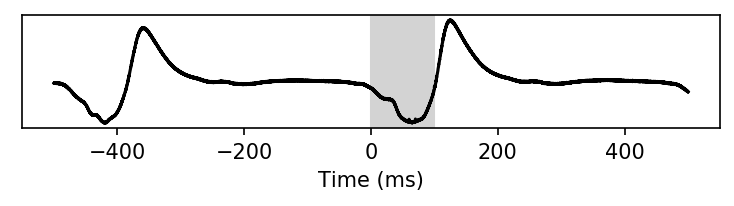

In [518]:
trial_start = rec.trial_starts[1500]
xs=  np.arange(-500, 500, 1/30)
plt.figure(figsize=(6, 1), dpi=150)
plt.plot(xs, rec_channel[trial_start-15000:trial_start+15000], color='k')
plt.yticks([])
plt.axvspan(0, 100, color='lightgray')
plt.xlabel('Time (ms)')

In [9]:
def time_minimisation(coords, true_distances):
    coords = coords.reshape(32, 50)
    

In [173]:
def dask_de(dm, tol=0.0001):
    bounds = [[-1000, 1000]]*32
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[dm])
    return de

In [174]:
de_futures = [dask.delayed(dask_de)(dms[i]) for i in range(50)]

In [175]:
de_outs = client.compute(de_futures)

In [176]:
dasked.current_futures = de_outs

In [198]:
dasked.check_progress()

finished 50


In [199]:
de_res = [i.result() for i in de_outs]

In [202]:
print(len())

50


In [203]:
distances = np.array([i.x for i in de_res])

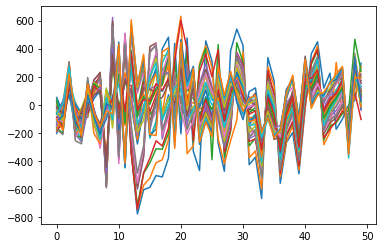

In [205]:
for i in range(32):
    plt.plot(distances[:, i])

In [120]:
bounds = [[-1000, 1000]]*32
print(bounds)
des = []
for i in tqdm(range(10)):
    de = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[dms[i]])
    des.append(de)



  0%|          | 0/10 [00:00<?, ?it/s]

[[-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000], [-1000, 1000]]




 10%|█         | 1/10 [00:10<01:31, 10.17s/it]

 20%|██        | 2/10 [00:16<01:12,  9.09s/it]

 30%|███       | 3/10 [00:22<00:57,  8.17s/it]

 40%|████      | 4/10 [00:32<00:51,  8.61s/it]

 50%|█████     | 5/10 [00:41<00:44,  8.86s/it]

 60%|██████    | 6/10 [00:50<00:35,  8.92s/it]

 70%|███████   | 7/10 [00:57<00:24,  8.31s/it]

 80%|████████  | 8/10 [01:07<00:17,  8.73s/it]

 90%|█████████ | 9/10 [01:14<00:08,  8.35s/it]

100%|██████████| 10/10 [01:21<00:00,  8.18s/it]


In [100]:
print(mean_usrt.shape)

(145, 32, 50)


In [107]:
normed_usrt1 = mean_usrt - np.mean(mean_usrt, axis=1)[:, np.newaxis]

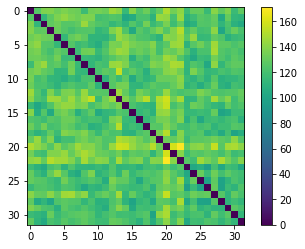

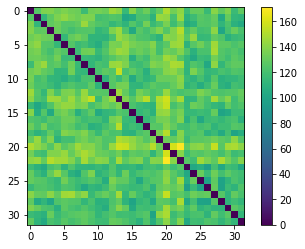

In [114]:
dm_test = distance_matrix(normed_usrt1[:, :, 0].T, normed_usrt1[:, :, 0].T)
plt.imshow(dm_test)
plt.colorbar()
plt.figure()
plt.imshow(dms[0])
plt.colorbar()

In [62]:
mds = MDS(n_components=1,)
des = []
for i in trange(50):
    out = mds.fit_transform(mean_usrt[:, :, i].T, )
#     if i > 0:
#         diff = np.sum(np.abs(des[-1] - out[:, 0]))
#         diff_flip = np.sum(np.abs(des[-1] +out[:, 0]))
#         if diff < diff_flip:
#             des.append(out[:, 0])
#         else:
#             des.append(-out[:, 0])
#     else:
    des.append(out[:, 0])


100%|██████████| 50/50 [00:00<00:00, 171.56it/s]


In [66]:
out = mds.fit_transform(mean_usrt.reshape(145, -1).T)
print(out.shape)

(1600, 1)


In [115]:
print(mean_usrt.shape)

normed_usrt = mean_usrt - np.mean(mean_usrt, axis=1)[:, np.newaxis]


(145, 32, 50)


In [116]:
out = mds.fit_transform(normed_usrt.reshape(145, -1).T)
print(out.shape)

(1600, 1)


In [117]:
out_reshaped = out.T.reshape(32, 50)

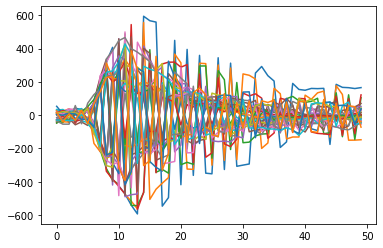

In [118]:
for i in out_reshaped:
    plt.plot(i)

In [64]:
mean_usrt[:, :, i].T.shape

(32, 145)

In [144]:
mds = MDS(n_components=1)
out = mds.fit_transform(mean_usrt.reshape(145, -1).T)

In [148]:
out_reshaped = out.T.reshape(32, 50)

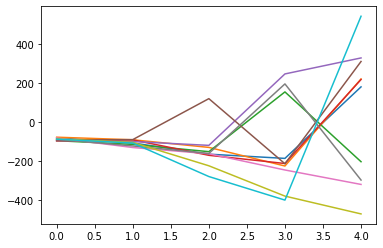

In [155]:
plt.plot(out_reshaped.T[5:10, :10]);

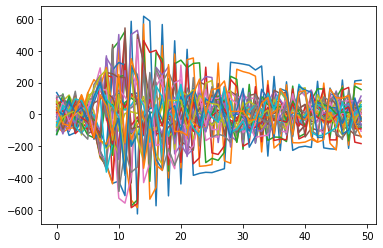

In [63]:
plt.plot(np.array(des));

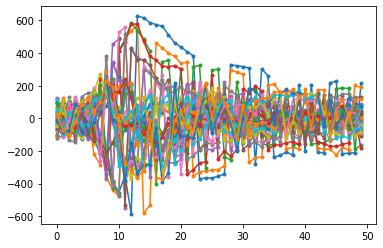

In [132]:
plt.plot(np.array(des), '.-');

In [167]:
# distances = [i.x for i in des]
distances = [i.x for i in de_res]

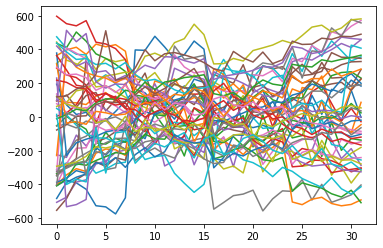

In [168]:
for i in distances:
    plt.plot(i)

In [11]:
distances = np.array(distances)
distances = distances - np.mean(distances, axis=1)[:, np.newaxis]
print(distances.shape)

(20, 32)


In [58]:
distances_flipped = [distances[0]]
for i in range(1, 50):
    prev_distance = distances_flipped[i-1]
    distance = distances[i]
    #print(distance)
    #rint(prev_distance)
#     print(np.sum(abs(distance - prev_distance)), np.sum(abs(distance + prev_distance)))
#     print('a')
    if np.sum(abs(distance - prev_distance )) < np.sum(abs(distance + prev_distance)):
        distances_flipped.append(distance)
    else:
        distances_flipped.append(-distance)

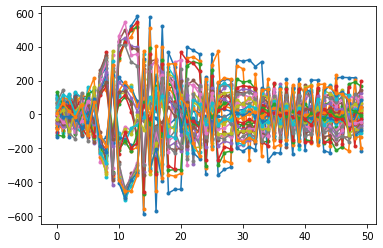

In [14]:
for i in range(32):
    plt.plot(distances[:, i] - np.mean(distances, axis=1), '.-')

Text(0, 0.5, 'Euclidean distance (Hz)')

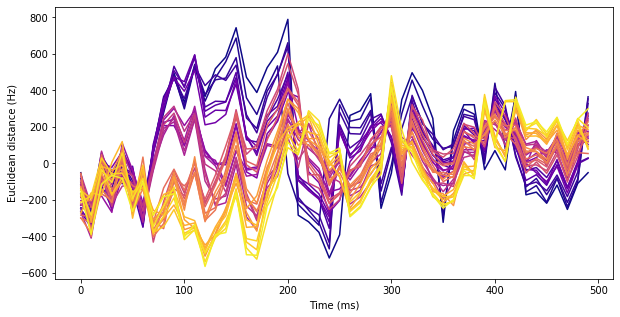

In [206]:
plt.figure(figsize=(10, 5))
xs = np.arange(0, 500, 10)
for index, i in enumerate(np.array(distances_flipped).T):
    plt.plot(xs, i, color=matplotlib.cm.plasma(index/32))
plt.xlabel('Time (ms)')
plt.ylabel('Euclidean distance (Hz)')
#plt.xlim(0, 200)

In [26]:
mds = MDS(n_components=1)
mean_usrt[:, :, :10].reshape(145, -1).T.shape
fit_test = mds.fit_transform(mean_usrt[:, :, 150:153].reshape(145, -1).T)

In [28]:
fit_test.T.reshape(32, 3).shape

(32, 3)


In [52]:
def de_minimisation(coords, true_distances):
    coords = coords[:, np.newaxis]
    dm = distance_matrix(coords, coords)
    loss = np.sum(np.abs(true_distances.ravel() - dm.ravel()))
    return loss

In [40]:
dms = [distance_matrix(mean_usrt[:, :, i].T, mean_usrt[:, :, i].T) for i in range(212)]
print(type(dms[150]))

<class 'numpy.ndarray'>


In [62]:
print(mean_usrt.shape)

(145, 32, 212)


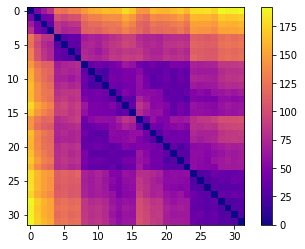

In [108]:
plt.imshow(dms[100], cmap='plasma')
plt.colorbar()

In [109]:
des = []
for i in trange(50, 100):
    bounds = [[-1000, 1000]]*32

    opt_out  = scipy.optimize.differential_evolution(de_minimisation, bounds=bounds, args=[dms[i]])
    des.append(opt_out.x)

100%|██████████| 50/50 [07:26<00:00,  8.93s/it]


In [98]:
print(opt_out)

     fun: 15524.123773911135
     jac: array([-2.000162  ,  1.9999801 , -1.99997868, -1.99979678,  2.00016076,
       -1.99997886, -1.99997868,  1.99997868,  2.00016076,  6.00011795,
        1.99997868,  1.99997868, -1.99979821,  2.00016058, -1.9999801 ,
       -1.9999801 ,  2.00016058,  2.00016058,  1.99997868, -1.99997886,
       -1.99997868,  2.00016058, -1.99997868, -1.99997868, -1.99997868,
        1.99997868, -1.9999801 , -1.99979678, -1.9999801 ,  2.000162  ,
       -1.9999801 ,  2.000162  ])
 message: 'Optimization terminated successfully.'
    nfev: 75672
     nit: 144
 success: True
       x: array([-89.70218701, -70.30486545, -63.5732576 , -40.56045635,
         5.21640636,  -5.58618409,   8.50103385,  23.17093687,
        -3.70130178,  15.12530364,  47.86569537,  41.24830696,
        64.10613266,  61.57345971,  82.3116538 ,  77.99444798,
       -33.53760179, -17.64549623,  11.38146377,  -6.19989964,
        29.80251113,  44.77558224,  62.91968594,  53.13925291,
        28.3

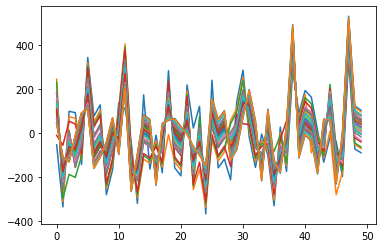

In [99]:
des = np.array(des)
for i in des.T:
    plt.plot(i)

In [ ]:
plt.plot()

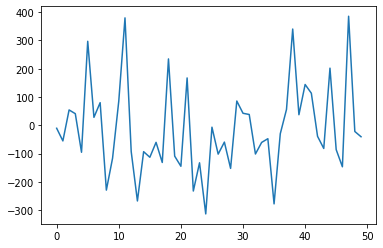

In [106]:
plt.plot(des[:, 3])

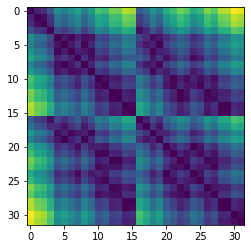

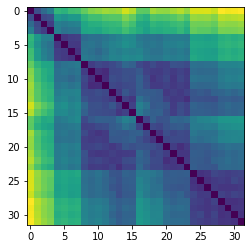

In [107]:
dm = distance_matrix(opt_out.x[:, np.newaxis], opt_out.x[:, np.newaxis])
plt.imshow(dm)
plt.figure()
plt.imshow(dms[100])

In [80]:
dm = distance_matrix(de.x.reshape(32, 2), de.x.reshape(32, 2))

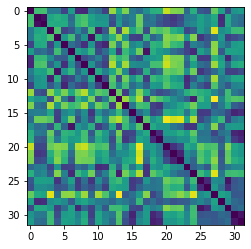

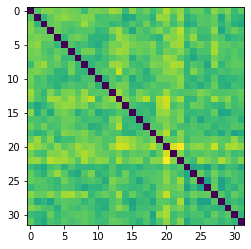

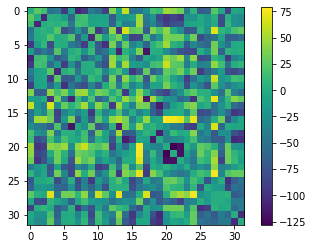

In [84]:
plt.imshow(dm)
plt.figure()
plt.imshow(dms[0])
plt.figure()
plt.imshow(dm-dms[0])
plt.colorbar()

In [51]:
lle = LocallyLinearEmbedding(n_neighbors=146)
lle_fit = lle.fit_transform(mean_usrt.T)

In [52]:
lle_fit = lle_fit.T.reshape(2, 32, 50)

In [53]:
print(lle_fit.shape)

(2, 32, 50)


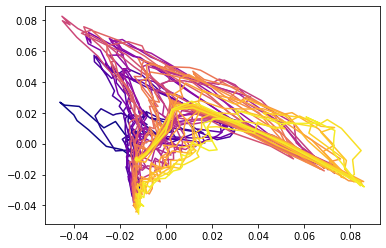

In [56]:
for i in range(32):
    plt.plot(lle_fit[0, i], lle_fit[1, i], color=matplotlib.cm.plasma(i/32))


In [58]:
print(mean_usrt.shape)

(145, 1600)
